In [2]:
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from matplotlib.pyplot import imshow
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2
from skimage import color

In [3]:
def RGBtoYCC(arr):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = arr.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [4]:
def YCCtoRGB(arr):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = arr.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [5]:
def RGBtoGray(arr):
    ycc = RGBtoYCC(arr)
    ret = np.zeros_like(ycc[:, :, 0])
    ret[:, :] = ycc[:, :, 0]
    return ret

In [6]:
def YCCtoGray(arr):
    ret = np.zeros_like(arr[:, :, 0])
    ret[:, :] = arr[:, :, 0]
    return ret

In [7]:
def crop_center(img, cropx, cropy):
    y, x, C = img.shape
    if y > cropy and x > cropx:
        startx = x//2 - (cropx//2)
        starty = y//2 - (cropy//2)    
        return img[starty:starty+cropy, startx:startx+cropx, :]
    else:
        return None

In [8]:
train_dir = './train2017/'

image_names = os.listdir(train_dir)
print(len(image_names))

%matplotlib inline

117285


In [8]:
# some of the images might not be the right size
# these are the dimenions with which we are working
H = 256
W = 256
C = 3

H_resnet = 299
W_resnet = 299

In [92]:
inception = tf.keras.applications.InceptionResNetV2(include_top=True, weights="imagenet")
for layer in inception.layers:
    layer.trainable = False
inception_output_size = 1000

In [10]:
def normalize_image(arr):
    return 2 * (arr / 255.) - 1.0

def denormalize_image(arr):
    return (arr + 1.0) * 255. // 2

In [11]:
def prep_for_res(x, H_resnet, W_resnet):
    H, W = x.shape
    stacked = np.zeros((H, W, 3))
    stacked[:, :, 0] = x[:, :]
    stacked[:, :, 1] = x[:, :]
    stacked[:, :, 2] = x[:, :]
    return cv2.resize(stacked, dsize=(H_resnet, W_resnet))

In [12]:
def process_image(arr, H, W, H_resnet, W_resnet):
    if len(arr.shape) == 3:
        cropped = crop_center(arr, H, W)
        if cropped is not None:
            arr = RGBtoYCC(cropped)
            gray = YCCtoGray(arr)
            upped = prep_for_res(gray, H_resnet, W_resnet)
            arr = normalize_image(arr)
            upped = normalize_image(upped)
            return arr[:, :, 0], upped, arr[:, :, 1:]
        return None, None, None
    return None, None, None

In [58]:
used_images = []
def generator(image_folder, batch_size):
    batch_features = np.zeros((batch_size, H, W, 1))
    batch_inception_embedding = np.zeros((batch_size, inception_output_size))
    batch_labels = np.zeros((batch_size, H, W, C - 1))
    
    filenames = os.listdir(image_folder)
    
    while True:
        count = 0
        while count < batch_size:
            filename = random.choice(filenames)
            arr = np.load(os.path.join(image_folder, filename))
            x, x_res, y = process_image(arr, H, W, H_resnet, W_resnet)
            if x is not None:
                used_images.append(filename)
                
                batch_features[count, :, :, :] = x[:, :, np.newaxis]
                batch_labels[count, :, :, :] = y

                with inception.graph.as_default():
                    res_output = inception.predict(x_res[np.newaxis, :, :, :])
                res_output = np.squeeze(res_output)
                batch_inception_embedding[count, :] = res_output

                count += 1
        yield ([batch_features, batch_inception_embedding], batch_labels)

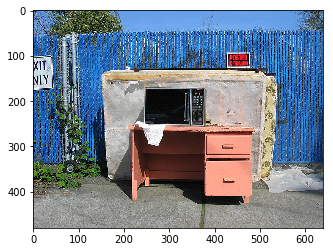

In [19]:
random_example = np.load("./train2017/000000436023.npy")
imshow(random_example)

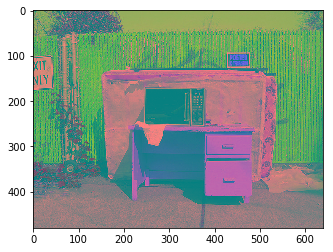

In [20]:
imshow(RGBtoYCC(random_example))

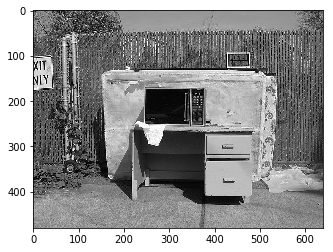

In [21]:
imshow(RGBtoGray(random_example), cmap="gray")

In [22]:
x, x_res, y = process_image(random_example, H, W, H_resnet, W_resnet)

(256, 256)


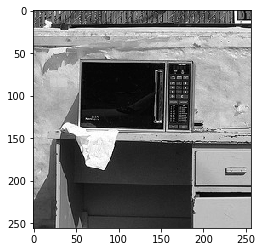

In [23]:
# the x
print(x.shape)
imshow(x, cmap="gray")

(256, 256, 2)
0.0


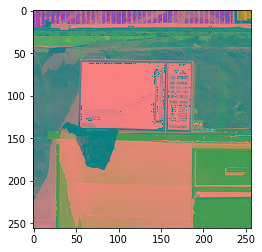

In [24]:
# the y
showing = np.zeros((y.shape[0], y.shape[1], y.shape[2] + 1))
print(y.shape)
showing[:, :, 0] = x[:, :]
showing[:, :, 1:] = y
showing = denormalize_image(showing)
print((showing - crop_center(RGBtoYCC(random_example), 256, 256)).max())
imshow(showing)

In [59]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 10

print('Using device: ', device)

Using device:  /device:GPU:0


In [60]:
model_file = 'model_inception.json'
weights_file = 'weights_inception.h5'
model_path = os.path.join("./", model_file)
weights_path = os.path.join("./", weights_file)
use_saved = False
save = True
train = True

In [61]:
def my_loss_function(y_true, y_pred):
    y_pred = 128 * y_pred
    y_true = 128 * y_true
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

In [78]:
input_shape = (H, W, C)


embed_input = tf.keras.layers.Input(shape=(inception_output_size,))

# Encoder
encoder_input = tf.keras.layers.Input(shape=(H, W, 1,))
encoder_output = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

# Fusion
fusion_output = tf.keras.layers.RepeatVector(32 * 32)(embed_input) 
fusion_output = tf.keras.layers.Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = tf.keras.layers.concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = tf.keras.layers.Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

# Decoder
decoder_output = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = tf.keras.layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = tf.keras.layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = tf.keras.layers.Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = tf.keras.layers.UpSampling2D((2, 2))(decoder_output)


my_model = None
if os.path.isfile(model_path) and os.path.isfile(weights_path) and use_saved:
    json_string = None
    with open(model_path, 'r') as f:
        json_string = json.load(f)
    my_model = tf.keras.models.model_from_json(json_string)
    my_model.load_weights(weights_path)
    print("loaded from save")
else:
    my_model = tf.keras.Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

my_model.summary()

my_model.compile(loss=my_loss_function, optimizer='adam')

if train:
    history = my_model.fit_generator(generator(train_dir, 4), steps_per_epoch=700, epochs=3)

if save:
    json_str = my_model.to_json()
    with open(model_path, 'w') as outfile:
        json.dump(json_str, outfile)
    my_model.save_weights(weights_path)
    print("saved weights and model")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_288 (Conv2D)             (None, 128, 128, 64) 640         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_289 (Conv2D)             (None, 128, 128, 128 73856       conv2d_288[0][0]                 
__________________________________________________________________________________________________
conv2d_290 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_289[0][0]                 
__________________________________________________________________________________________________
conv2d_291

208.10612757712897


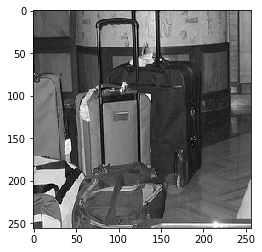

In [79]:
image_name = used_images[-1]
showoff = np.load(os.path.join("./train2017/", image_name))

showoff_x, showoff_x_inception_input, showoff_y = process_image(showoff, H, W, H_resnet, W_resnet)

res_output = inception.predict(showoff_x_inception_input[np.newaxis, :, :, :])
prediction = my_model.predict([showoff_x[np.newaxis, :, :, np.newaxis], res_output])
prediction = np.reshape(prediction, (H, W, 2))

print(np.mean((128 * (prediction - showoff_y))**2))

showoff_x = denormalize_image(showoff_x)
showoff_y = denormalize_image(showoff_y)
prediction = denormalize_image(prediction)

imshow(showoff_x, cmap="gray")

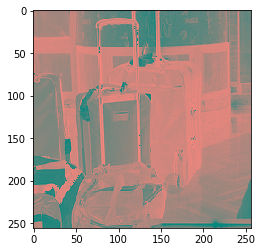

In [86]:
im = np.zeros((H, W, C))
im[:, :, 0] = showoff_x[:, :]
im[:, :, 1] = prediction[:, :, 0]
im[:, :, 2] = prediction[:, :, 1]
im[im < 0] = 0
imshow(im)

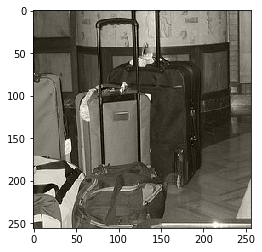

In [87]:
# converting into RGB gives us
imshow(YCCtoRGB(im))

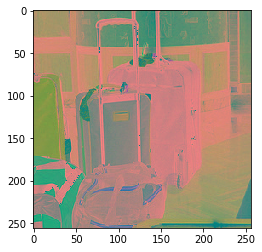

In [88]:
should_be = np.zeros((H, W, C))
should_be[:, :, 0] = showoff_x[:, :]
should_be[:, :, 1] = showoff_y[:, :, 0]
should_be[:, :, 2] = showoff_y[:, :, 1]
imshow(should_be)

In [98]:
print(np.mean((im - should_be)[:, :, 1:]))

-2.3590621948242188


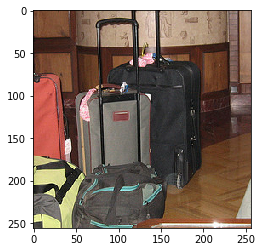

In [83]:
# real image
imshow(YCCtoRGB(should_be))